# Padding and strides
The default strides is one for networks. This indicates that the model convolves one input over
each axis (step size of one). However, when a dataset contains less granular information on the pixel level, we can experiment with larger values as strides. By increasing the strides, the convolutional layer skips more input variables over each axis, and therefore the number of trainable parameters is reduced. This can speed up convergence without too much performance loss.<br><br>
Another parameter that can be tuned is the padding. The padding defines how the borders of the input data (for example images) are handled. If no padding is added, only the border pixels (in the case of an image) will be included. So if you expect the borders to include valuable information, you can try to add padding to your data. This adds a border of dummy data that can be used while convolving over the data. A benefit of using padding is that the dimensions of the data are kept the same over each convolutional layer, which means that you can stack more convolutional layers on top of each other. In the following diagram, we can see an example of stride 1 with zero padding, and an example of stride 2 with padding:
![alt text][logo]

[logo]: https://github.com/sara-kassani/Python-Deep-Learning-Cookbook/blob/master/data/padding.png?raw=true "Padding and Strides"
There is no general rule for which value to choose for the padding and strides. It largely depends on the size and
complexity of the data in combination with the potential pre-processing techniques used. Next, we will experiment with different settings for the strides and padding and compare the results of our models. The dataset we will use contains images of cats and dogs, and our task is to classify the animal.

In [1]:
import glob
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D

SEED = 2017

Using TensorFlow backend.


In [2]:
# Data can be downloaded at https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

### Loading the filenames and outputting the training set sizes

In [3]:
# Specify data directory and extract all file names for both classes
DATA_DIR = 'data/'
cats = glob.glob(DATA_DIR + "Cat/*.jpg")
dogs = glob.glob(DATA_DIR + "Dog/*.jpg")

print('#Cats: {}, #Dogs: {}'.format(len(cats), len(dogs)))
# #Cats: 12500, #Dogs: 12500

#Cats: 12500, #Dogs: 12500


### To get a better understanding of the dataset, let's plot three examples of each class:

In [4]:
dogs_train, dogs_val, cats_train, cats_val = train_test_split(dogs, cats, test_size=0.2, random_state=SEED)

### Split the dataset in a training and validation set

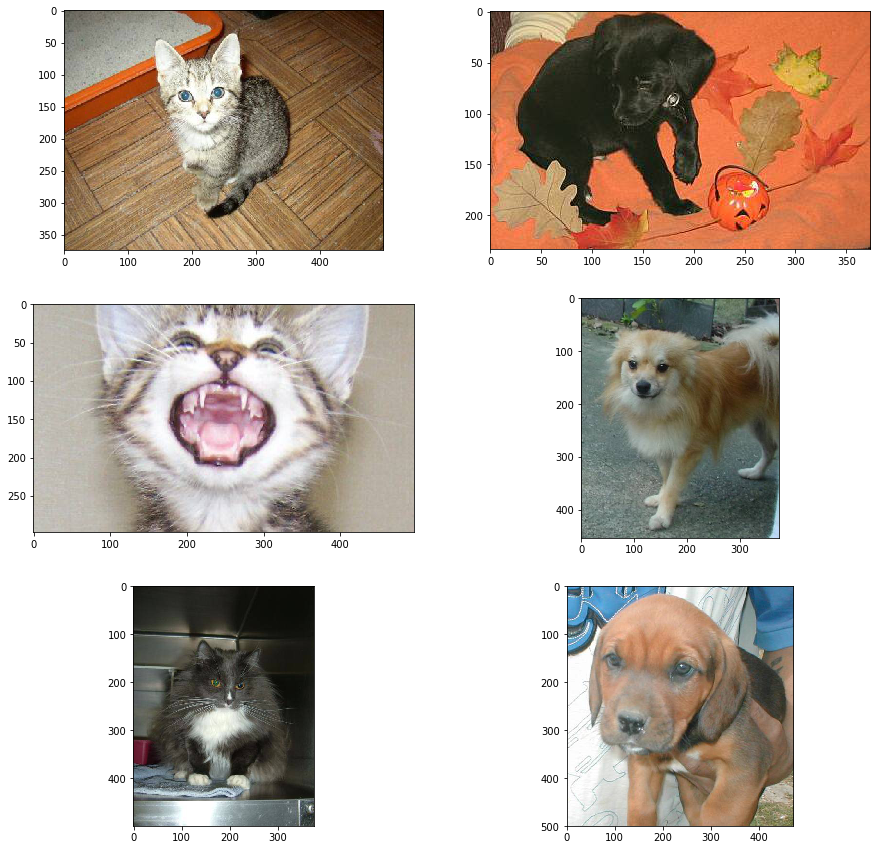

In [5]:
n_examples = 3
plt.figure(figsize=(15, 15))
i = 1
for _ in range(n_examples):
    image_cat = cats_train[np.random.randint(len(cats_train))]
    img_cat = cv2.imread(image_cat)
    img_cat = cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 2, i)
    _ = plt.imshow(img_cat)
    i += 1
    image_dog = dogs_train[np.random.randint(len(dogs_train))]
    img_dog = cv2.imread(image_dog)
    img_dog = cv2.cvtColor(img_dog, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 2, i)
    i += 1
    _ = plt.imshow(img_dog)
plt.show()

### The training set is relatively large; we will be using a batch generator so that we don't have to load all images in memory

In [6]:
def batchgen(cats, dogs, batch_size, img_size=50):
    # Create empty numpy arrays
    batch_images = np.zeros((batch_size, img_size, img_size, 3))
    batch_label = np.zeros(batch_size)

    # Custom batch generator 
    while 1:
        n = 0
        while n < batch_size:
            # Randomly pick a dog or cat image
            if np.random.randint(2) == 1:
                i = np.random.randint(len(dogs))
                img = cv2.imread(dogs[i])
                if img is None:
                    break
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # The images have different dimensions, we resize all to 100x100
                img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
                y = 1

            else:
                i = np.random.randint(len(cats))
                img = cv2.imread(cats[i])
                if img is None:
                    break
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
                y = 0
        
            batch_images[n] = img
            batch_label[n] = y
            n+=1
        yield batch_images, batch_label

### Define a function that creates a model given parameters for the stride and padding

In [7]:
def create_model(stride=1, padding='same', img_size=100):
    # Define architecture
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.) - 0.5, input_shape=(img_size, img_size, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding=padding, strides=stride))
    model.add(Conv2D(32, (3, 3), activation='relu', padding=padding, strides=stride))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), activation='relu', padding=padding, strides=stride))
    model.add(Conv2D(64, (3, 3), activation='relu', padding=padding, strides=stride))
    
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam(0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
    
    return model

### Define a model for each setting, and we extract the number of trainable parameters

In [8]:
img_size = 100

models = []
for stride in [1, 2]:
    for padding in ['same', 'valid']:
        model = create_model(stride, padding, img_size)
        pars = model.count_params()
        models.append(dict({'setting': '{}_{}'.format(stride, padding), 
                'model': model,
                'parameters': pars
                }))

### Output the scheme of a model

In [9]:
models[0]['model'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
__________

### Define a callback for early stopping

In [10]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', patience=5)]

### Train our models and store the results

In [11]:
batch_size = 512
n_epochs = 500
validation_steps = round((len(dogs_val)+len(cats_val))/batch_size)
steps_per_epoch = round((len(dogs_train)+len(cats_train))/batch_size)

train_generator = batchgen(dogs_train, cats_train, batch_size, img_size)
val_generator = batchgen(dogs_val, cats_val, batch_size, img_size)

history = []
for i in range(len(models)):
    print(models[i])
    history.append(
        models[i]['model'].
        fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=n_epochs, 
                            validation_data=val_generator, validation_steps=validation_steps,
                            callbacks=callbacks
                           )
    )

{'setting': '1_same', 'model': <keras.models.Sequential object at 0x7fa0cb1e3fd0>, 'parameters': 10305697}
Epoch 1/500
39/39 [==============================] - 671s 17s/step - loss: 0.7440 - binary_accuracy: 0.4973 - val_loss: 0.6916 - val_binary_accuracy: 0.5115
Epoch 2/500
39/39 [==============================] - 632s 16s/step - loss: 0.6832 - binary_accuracy: 0.5548 - val_loss: 0.6787 - val_binary_accuracy: 0.5803
Epoch 3/500
39/39 [==============================] - 633s 16s/step - loss: 0.6747 - binary_accuracy: 0.5782 - val_loss: 0.6702 - val_binary_accuracy: 0.5910
Epoch 4/500
39/39 [==============================] - 631s 16s/step - loss: 0.6630 - binary_accuracy: 0.6033 - val_loss: 0.6679 - val_binary_accuracy: 0.6008
Epoch 5/500
39/39 [==============================] - 631s 16s/step - loss: 0.6370 - binary_accuracy: 0.6383 - val_loss: 0.6245 - val_binary_accuracy: 0.6531
Epoch 6/500
39/39 [==============================] - 631s 16s/step - loss: 0.6134 - binary_accuracy: 0.6714 

39/39 [==============================] - 541s 14s/step - loss: 0.4652 - binary_accuracy: 0.7902 - val_loss: 0.4314 - val_binary_accuracy: 0.7945
Epoch 17/500
39/39 [==============================] - 543s 14s/step - loss: 0.4434 - binary_accuracy: 0.8077 - val_loss: 0.4342 - val_binary_accuracy: 0.7904
Epoch 18/500
39/39 [==============================] - 542s 14s/step - loss: 0.4233 - binary_accuracy: 0.8173 - val_loss: 0.4284 - val_binary_accuracy: 0.8006
Epoch 19/500
39/39 [==============================] - 543s 14s/step - loss: 0.4270 - binary_accuracy: 0.8168 - val_loss: 0.4234 - val_binary_accuracy: 0.8004
Epoch 20/500
39/39 [==============================] - 545s 14s/step - loss: 0.4028 - binary_accuracy: 0.8270 - val_loss: 0.4241 - val_binary_accuracy: 0.8172
Epoch 21/500
39/39 [==============================] - 541s 14s/step - loss: 0.4095 - binary_accuracy: 0.8259 - val_loss: 0.4061 - val_binary_accuracy: 0.8152
Epoch 22/500
39/39 [==============================] - 577s 15s/st

Epoch 34/500
39/39 [==============================] - 62s 2s/step - loss: 0.3530 - binary_accuracy: 0.8466 - val_loss: 0.3917 - val_binary_accuracy: 0.8322
Epoch 35/500
39/39 [==============================] - 62s 2s/step - loss: 0.3509 - binary_accuracy: 0.8491 - val_loss: 0.3600 - val_binary_accuracy: 0.8416
Epoch 36/500
39/39 [==============================] - 63s 2s/step - loss: 0.3487 - binary_accuracy: 0.8502 - val_loss: 0.4112 - val_binary_accuracy: 0.8176
Epoch 37/500
39/39 [==============================] - 63s 2s/step - loss: 0.3480 - binary_accuracy: 0.8508 - val_loss: 0.3547 - val_binary_accuracy: 0.8480
Epoch 38/500
39/39 [==============================] - 64s 2s/step - loss: 0.3419 - binary_accuracy: 0.8526 - val_loss: 0.3712 - val_binary_accuracy: 0.8379
Epoch 39/500
39/39 [==============================] - 62s 2s/step - loss: 0.3309 - binary_accuracy: 0.8586 - val_loss: 0.3774 - val_binary_accuracy: 0.8408
Epoch 40/500
39/39 [==============================] - 61s 2s/ste

### Visualize the results

Max accuracy model 1_same: 0.8287109375
Max accuracy model 1_valid: 0.83984375
Max accuracy model 2_same: 0.86328125
Max accuracy model 2_valid: 0.83828125


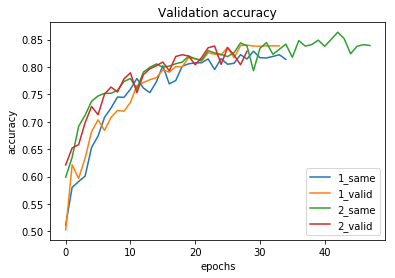

In [12]:
for i in range(len(models)):
    plt.plot(range(len(history[i].history['val_binary_accuracy'])), history[i].history['val_binary_accuracy'], label=models[i]['setting'])
    print('Max accuracy model {}: {}'.format(models[i]['setting'], max(history[i].history['val_binary_accuracy'])))
plt.title('Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Performance comparison with different settings for padding and strides

### Print Accuracies

In [13]:
for i in range(len(models)):
    plt.plot(range(len(history[i].history['val_binary_accuracy'])), history[i].history['val_binary_accuracy'], label=models[i]['setting'])
    print('Max accuracy model {}: {} (#parameters: {})'.format(models[i]['setting'], max(history[i].history['val_binary_accuracy']), models[i]['parameters']))

Max accuracy model 1_same: 0.8287109375 (#parameters: 10305697)
Max accuracy model 1_valid: 0.83984375 (#parameters: 7995553)
Max accuracy model 2_same: 0.86328125 (#parameters: 102561)
Max accuracy model 2_valid: 0.83828125 (#parameters: 82081)


By using a stride of 2, the number of trainable parameters are reduced significantly (from 10,305,697 to 102,561 when using adding). For this dataset, it shows that there is no performance loss by using a stride > 1. This is expected, because we use (resized) 100 x 100 x 3 images as input. Skipping a pixel in each direction shouldn't influence the performance too much.